In [ ]:
######################## Pre Processing Implementation of Canny #####################
import cv2
import os
import numpy as np
import albumentations as A

def preprocess_images(input_dir, raw_aug_dir, processed_aug_dir, num_aug=3):
    """
    Applies augmentation and Canny edge detection, saving results in separate folders.

    Args:
        input_dir (str): Path to original images.
        raw_aug_dir (str): Path to save augmented images.
        processed_aug_dir (str): Path to save Canny-processed images.
        num_aug (int): Number of augmented copies per image.
    """
    # Create output directories if they don't exist
    os.makedirs(raw_aug_dir, exist_ok=True)
    os.makedirs(processed_aug_dir, exist_ok=True)

    # Define augmentation pipeline
    transform = A.Compose([
        A.Resize(240, 240),
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ], p=0.7),
        A.RandomBrightnessContrast(p=0.2)
    ])

    for root, _, files in os.walk(input_dir):
        relative_path = os.path.relpath(root, input_dir)

        # Create corresponding subdirectories in new folders
        raw_aug_subdir = os.path.join(raw_aug_dir, relative_path)
        processed_aug_subdir = os.path.join(processed_aug_dir, relative_path)
        os.makedirs(raw_aug_subdir, exist_ok=True)
        os.makedirs(processed_aug_subdir, exist_ok=True)

        for img_name in files:
            try:
                img_path = os.path.join(root, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    print(f"Skipped: {img_path} (not a valid image)")
                    continue

                for i in range(num_aug):  # Generate multiple augmentations
                    augmented = transform(image=img)
                    img_aug = augmented["image"]

                    # Save augmented image (before Canny)
                    raw_aug_path = os.path.join(raw_aug_subdir, f"{os.path.splitext(img_name)[0]}_aug{i}.png")
                    cv2.imwrite(raw_aug_path, img_aug)

                    # Apply Gaussian Blur
                    img_blur = cv2.GaussianBlur(img_aug, (5, 5), 0)

                    # Apply Canny edge detection
                    edges = cv2.Canny(img_blur, 50, 150)

                    # Save processed (Canny) image
                    processed_aug_path = os.path.join(processed_aug_subdir, f"{os.path.splitext(img_name)[0]}_aug{i}.png")
                    cv2.imwrite(processed_aug_path, edges)

            except Exception as e:
                print(f"Error processing {img_name}: {e}")

    print(f"Processing complete.\nAugmented images saved in: {raw_aug_dir}\nProcessed Canny images saved in: {processed_aug_dir}")

# Example usage:
preprocess_images("data/raw_images", "data/raw_aug_2", "data/processed_aug_2")


Processing complete.
Augmented images saved in: data/raw_aug_2
Processed Canny images saved in: data/processed_aug_2


Epoch 1: Train Loss=0.4618, Train Acc=78.11%, Val Loss=0.3398, Val Acc=86.76%
Epoch 2: Train Loss=0.2577, Train Acc=90.52%, Val Loss=0.2281, Val Acc=91.01%
Epoch 3: Train Loss=0.1542, Train Acc=95.72%, Val Loss=0.1633, Val Acc=93.81%
Epoch 4: Train Loss=0.0944, Train Acc=98.34%, Val Loss=0.1238, Val Acc=95.25%
Epoch 5: Train Loss=0.0651, Train Acc=99.30%, Val Loss=0.1031, Val Acc=96.55%
Epoch 6: Train Loss=0.0421, Train Acc=99.71%, Val Loss=0.0937, Val Acc=96.04%
Epoch 7: Train Loss=0.0309, Train Acc=99.90%, Val Loss=0.0857, Val Acc=96.55%
Epoch 8: Train Loss=0.0243, Train Acc=99.96%, Val Loss=0.0782, Val Acc=97.27%
Epoch 9: Train Loss=0.0221, Train Acc=99.98%, Val Loss=0.1108, Val Acc=95.83%
Epoch 10: Train Loss=0.0187, Train Acc=99.98%, Val Loss=0.0733, Val Acc=97.27%
Epoch 11: Train Loss=0.0143, Train Acc=100.00%, Val Loss=0.0715, Val Acc=97.27%
Epoch 12: Train Loss=0.0164, Train Acc=99.98%, Val Loss=0.0852, Val Acc=96.98%
Epoch 13: Train Loss=0.0145, Train Acc=99.98%, Val Loss=0.07

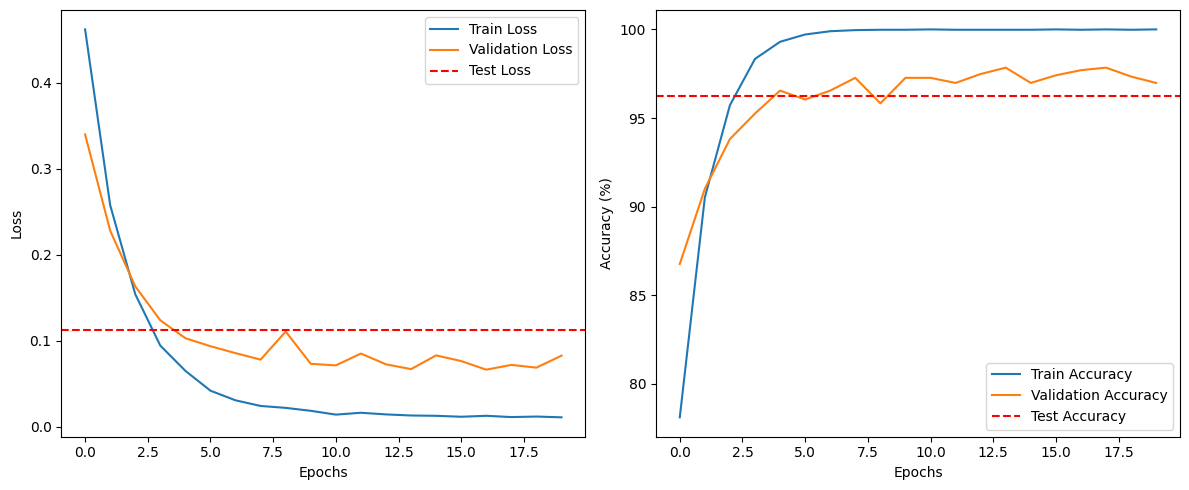

In [ ]:
################################## Base Code ####################
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

class BrainTumorDataset(Dataset):
    def __init__(self, processed_dir, raw_dir, labels, transform=None):
        self.processed_dir = processed_dir
        self.raw_dir = raw_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels[idx]['image']
        label = self.labels[idx]['label']

        processed_path = os.path.join(self.processed_dir, img_name)
        raw_path = os.path.join(self.raw_dir, img_name)

        if not os.path.exists(processed_path) or not os.path.exists(raw_path):
            raise FileNotFoundError(f"Missing image: {img_name} in {self.processed_dir} or {self.raw_dir}")

        # Load processed (Canny) image
        image = Image.open(processed_path).convert('RGB')

        # Load raw mask (Grayscale)
        mask = Image.open(raw_path).convert('L')

        # Resize both images
        resize_transform = transforms.Resize((224, 224))
        image = resize_transform(image)
        mask = resize_transform(mask)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Convert mask to tensor (without normalization)
        mask = transforms.ToTensor()(mask)

        return image, mask, label


# Function to generate labels
def generate_labels(image_dir):
    labels = []
    for label, folder in enumerate(['yes', 'no']):
        folder_path = os.path.join(image_dir, folder)
        if not os.path.exists(folder_path):
            continue
        for img_name in os.listdir(folder_path):
            labels.append({'image': os.path.join(folder, img_name), 'label': label})
    return labels

# Save test images
def save_test_images(test_labels, processed_dir, raw_dir, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for item in test_labels:
        for src_dir in [processed_dir, raw_dir]:
            src_path = os.path.join(src_dir, item['image'])
            dest_dir = os.path.join(output_folder, os.path.dirname(item['image']))
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(src_path, os.path.join(dest_dir, os.path.basename(item['image'])))

# Data paths
processed_image_dir = 'data/processed_aug_2'
raw_image_dir = 'data/raw_aug_2'
test_output_dir = 'test_images'

# Generate labels & split dataset
labels = generate_labels(processed_image_dir)
if len(labels) == 0:
    raise ValueError("No images found! Check dataset directories.")

train_labels, temp_labels = train_test_split(labels, test_size=0.3, random_state=42)
val_labels, test_labels = train_test_split(temp_labels, test_size=1/3, random_state=42)

# Save test images
save_test_images(test_labels, processed_image_dir, raw_image_dir, test_output_dir)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, train_labels, transform)
val_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, val_labels, transform)
test_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, test_labels, transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model setup
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Lists for storing loss and accuracy
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

# Training loop
for epoch in range(20):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, masks, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, masks, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.2f}%, Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.2f}%")

# Testing
model.eval()
test_loss, correct_test, total_test = 0.0, 0, 0
with torch.no_grad():
    for images, masks, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = 100 * correct_test / total_test
test_losses.append(avg_test_loss)
test_accuracies.append(test_accuracy)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.axhline(avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.axhline(test_accuracy, color='r', linestyle='--', label="Test Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()


Epoch 1: Train Loss=0.4708, Train Acc=76.94%, Val Loss=0.3375, Val Acc=86.91%
Epoch 2: Train Loss=0.2735, Train Acc=89.76%, Val Loss=0.2260, Val Acc=92.01%
Epoch 3: Train Loss=0.1682, Train Acc=95.29%, Val Loss=0.1573, Val Acc=95.40%
Epoch 4: Train Loss=0.1007, Train Acc=98.56%, Val Loss=0.1179, Val Acc=96.69%
Epoch 5: Train Loss=0.0592, Train Acc=99.49%, Val Loss=0.0938, Val Acc=97.19%
Epoch 6: Train Loss=0.0438, Train Acc=99.88%, Val Loss=0.0796, Val Acc=97.70%
Epoch 7: Train Loss=0.0317, Train Acc=99.98%, Val Loss=0.0753, Val Acc=97.55%
Epoch 8: Train Loss=0.0257, Train Acc=99.98%, Val Loss=0.0690, Val Acc=97.77%
Epoch 9: Train Loss=0.0220, Train Acc=99.98%, Val Loss=0.0658, Val Acc=97.55%
Epoch 10: Train Loss=0.0178, Train Acc=99.98%, Val Loss=0.0646, Val Acc=97.77%
Epoch 11: Train Loss=0.0169, Train Acc=100.00%, Val Loss=0.0626, Val Acc=97.70%
Epoch 12: Train Loss=0.0141, Train Acc=100.00%, Val Loss=0.0674, Val Acc=97.99%
Epoch 13: Train Loss=0.0158, Train Acc=99.98%, Val Loss=0.0

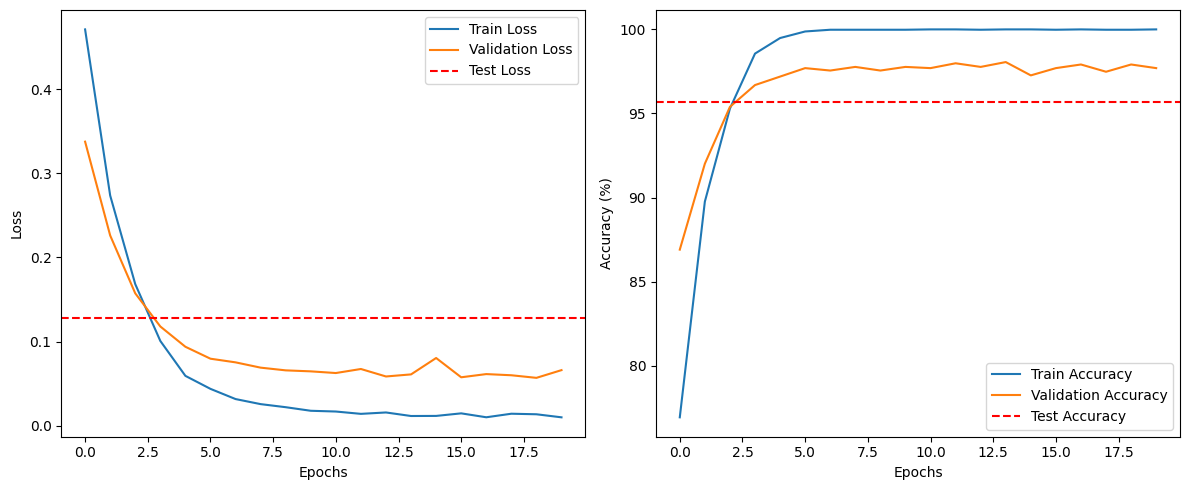

In [ ]:
#################################### Code With GradCam ###########################
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

class BrainTumorDataset(Dataset):
    def __init__(self, processed_dir, raw_dir, labels, transform=None):
        self.processed_dir = processed_dir
        self.raw_dir = raw_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels[idx]['image']
        label = self.labels[idx]['label']

        processed_path = os.path.join(self.processed_dir, img_name)
        raw_path = os.path.join(self.raw_dir, img_name)

        if not os.path.exists(processed_path) or not os.path.exists(raw_path):
            raise FileNotFoundError(f"Missing image: {img_name} in {self.processed_dir} or {self.raw_dir}")

        # Load processed (Canny) image
        image = Image.open(processed_path).convert('RGB')

        # Load raw mask (Grayscale)
        mask = Image.open(raw_path).convert('L')

        # Resize both images
        resize_transform = transforms.Resize((224, 224))
        image = resize_transform(image)
        mask = resize_transform(mask)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Convert mask to tensor (without normalization)
        mask = transforms.ToTensor()(mask)

        return image, mask, label

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, gradients, activations):
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        activations = activations[0]  # Batch size is 1
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap

    def __call__(self, input_tensor, class_idx=None):
        self.model.eval()

        # Move input to the correct device
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        input_tensor.requires_grad_()
        for param in self.model.parameters():
            param.requires_grad = True  

        with torch.set_grad_enabled(True):
            output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad() 
        class_score = output[:, class_idx]

        # Compute Gradients
        class_score.backward(retain_graph=True)

        heatmap = self.generate_heatmap(self.gradients, self.activations)
        return heatmap

# Save Grad-CAM images
def save_gradcam_images(gradcam, input_tensor, original_image_paths, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for i in range(input_tensor.size(0)):
        heatmap = gradcam(input_tensor[i:i + 1])

        # Load original image for overlay
        original_image = cv2.imread(original_image_paths[i])
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Resize heatmap to original image size
        heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        # Overlay heatmap on the original image
        overlayed_image = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

        # Save overlayed image
        output_path = os.path.join(output_folder, f"gradcam_{i}.jpg")
        cv2.imwrite(output_path, cv2.cvtColor(overlayed_image, cv2.COLOR_RGB2BGR))

# Function to generate labels
def generate_labels(image_dir):
    labels = []
    for label, folder in enumerate(['yes', 'no']):
        folder_path = os.path.join(image_dir, folder)
        if not os.path.exists(folder_path):
            continue
        for img_name in os.listdir(folder_path):
            labels.append({'image': os.path.join(folder, img_name), 'label': label})
    return labels

# Save test images
def save_test_images(test_labels, processed_dir, raw_dir, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for item in test_labels:
        for src_dir in [processed_dir, raw_dir]:
            src_path = os.path.join(src_dir, item['image'])
            dest_dir = os.path.join(output_folder, os.path.dirname(item['image']))
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(src_path, os.path.join(dest_dir, os.path.basename(item['image'])))

# Data paths
processed_image_dir = 'data/processed_aug_2'
raw_image_dir = 'data/raw_aug_2'
test_output_dir = 'test_images'
grad_output_dir = 'grad_output'

# Generate labels & split dataset
labels = generate_labels(processed_image_dir)
if len(labels) == 0:
    raise ValueError("No images found! Check dataset directories.")

train_labels, temp_labels = train_test_split(labels, test_size=0.3, random_state=42)
val_labels, test_labels = train_test_split(temp_labels, test_size=1/3, random_state=42)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, train_labels, transform)
val_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, val_labels, transform)
test_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, test_labels, transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model setup
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Early Stop setup
best_val_loss = float('inf')
patience, patience_counter = 5, 0
best_model_path = 'best_model.pth'

# Lists for storing loss and accuracy
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

# Grad-CAM setup
gradcam = GradCAM(model, model.layer4)

# Training loop
for epoch in range(20):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, masks, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, masks, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.2f}%, Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
    else:
            patience_counter += 1
        
    if patience_counter >= patience:
            print("Early stopping triggered.")
            break

torch.save(model.state_dict(), 'final_model.pth')
print("Training completed. Best model and final model saved.")

# Testing with Grad-CAM output
model.eval()
test_loss, correct_test, total_test = 0.0, 0, 0
for images, masks, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

    # Save Grad-CAM images
    image_paths = [os.path.join(test_output_dir, label['image']) for label in test_labels]
    save_gradcam_images(gradcam, images, image_paths, grad_output_dir)

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.axhline(avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.axhline(test_accuracy, color='r', linestyle='--', label="Test Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()


Epoch 1: Train Loss=0.4724, Train Acc=76.53%, Val Loss=0.3326, Val Acc=86.26%
Epoch 2: Train Loss=0.2582, Train Acc=90.20%, Val Loss=0.2385, Val Acc=90.94%
Epoch 3: Train Loss=0.1529, Train Acc=95.91%, Val Loss=0.1636, Val Acc=93.88%
Epoch 4: Train Loss=0.0909, Train Acc=98.42%, Val Loss=0.1233, Val Acc=95.83%
Epoch 5: Train Loss=0.0524, Train Acc=99.57%, Val Loss=0.0998, Val Acc=96.55%
Epoch 6: Train Loss=0.0408, Train Acc=99.90%, Val Loss=0.0857, Val Acc=96.98%
Epoch 7: Train Loss=0.0307, Train Acc=99.96%, Val Loss=0.0816, Val Acc=96.98%
Epoch 8: Train Loss=0.0196, Train Acc=100.00%, Val Loss=0.0814, Val Acc=97.34%
Epoch 9: Train Loss=0.0153, Train Acc=100.00%, Val Loss=0.0964, Val Acc=96.47%
Epoch 10: Train Loss=0.0233, Train Acc=99.96%, Val Loss=0.0697, Val Acc=97.48%
Epoch 11: Train Loss=0.0189, Train Acc=99.98%, Val Loss=0.0702, Val Acc=97.41%
Epoch 12: Train Loss=0.0174, Train Acc=99.98%, Val Loss=0.0684, Val Acc=97.34%
Epoch 13: Train Loss=0.0174, Train Acc=99.98%, Val Loss=0.0

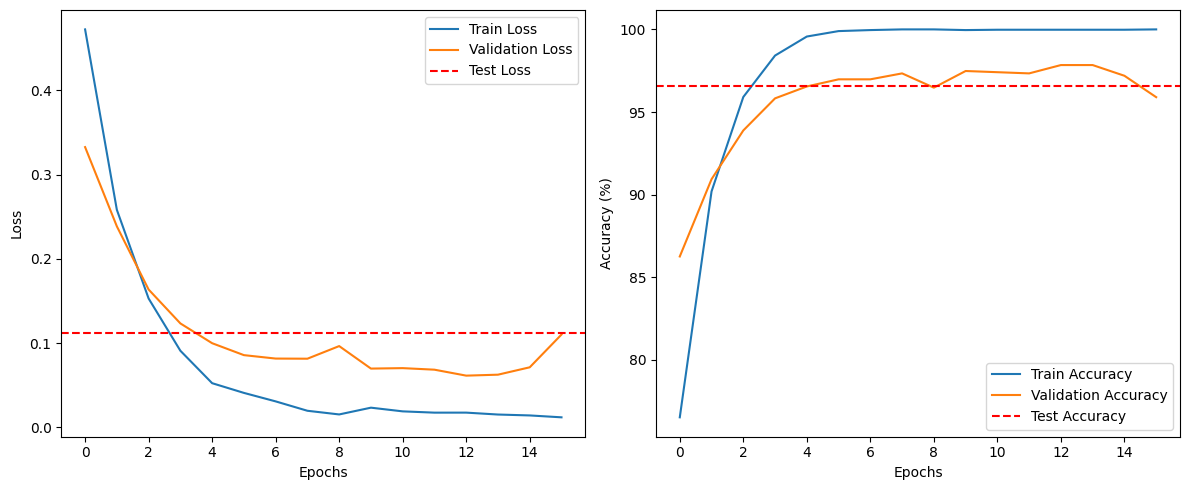

In [ ]:
############################## Code with GradCam & Early Stop #############################
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

class BrainTumorDataset(Dataset):
    def __init__(self, processed_dir, raw_dir, labels, transform=None):
        self.processed_dir = processed_dir
        self.raw_dir = raw_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels[idx]['image']
        label = self.labels[idx]['label']

        processed_path = os.path.join(self.processed_dir, img_name)
        raw_path = os.path.join(self.raw_dir, img_name)

        if not os.path.exists(processed_path) or not os.path.exists(raw_path):
            raise FileNotFoundError(f"Missing image: {img_name} in {self.processed_dir} or {self.raw_dir}")

        # Load processed (Canny) image
        image = Image.open(processed_path).convert('RGB')

        # Load raw mask (Grayscale)
        mask = Image.open(raw_path).convert('L')

        # Resize both images
        resize_transform = transforms.Resize((224, 224))
        image = resize_transform(image)
        mask = resize_transform(mask)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Convert mask to tensor (without normalization)
        mask = transforms.ToTensor()(mask)

        return image, mask, label

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, gradients, activations):
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        activations = activations[0]  # Batch size is 1
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap

    def __call__(self, input_tensor, class_idx=None):
        self.model.eval()

        # Move input to the correct device
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        input_tensor.requires_grad_()
        for param in self.model.parameters():
            param.requires_grad = True  

        with torch.set_grad_enabled(True):
            output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad() 
        class_score = output[:, class_idx]

        # Compute Gradients
        class_score.backward(retain_graph=True)

        heatmap = self.generate_heatmap(self.gradients, self.activations)
        return heatmap

# Save Grad-CAM images
def save_gradcam_images(gradcam, input_tensor, original_image_paths, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for i in range(input_tensor.size(0)):
        heatmap = gradcam(input_tensor[i:i + 1])

        # Load original image for overlay
        original_image = cv2.imread(original_image_paths[i])
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Resize heatmap to original image size
        heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        # Overlay heatmap on the original image
        overlayed_image = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

        # Save overlayed image
        output_path = os.path.join(output_folder, f"gradcam_{i}.jpg")
        cv2.imwrite(output_path, cv2.cvtColor(overlayed_image, cv2.COLOR_RGB2BGR))

# Function to generate labels
def generate_labels(image_dir):
    labels = []
    for label, folder in enumerate(['yes', 'no']):
        folder_path = os.path.join(image_dir, folder)
        if not os.path.exists(folder_path):
            continue
        for img_name in os.listdir(folder_path):
            labels.append({'image': os.path.join(folder, img_name), 'label': label})
    return labels

# Save test images
def save_test_images(test_labels, processed_dir, raw_dir, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for item in test_labels:
        for src_dir in [processed_dir, raw_dir]:
            src_path = os.path.join(src_dir, item['image'])
            dest_dir = os.path.join(output_folder, os.path.dirname(item['image']))
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(src_path, os.path.join(dest_dir, os.path.basename(item['image'])))

# Data paths
processed_image_dir = 'data/processed_aug_2'
raw_image_dir = 'data/raw_aug_2'
test_output_dir = 'test_images'
grad_output_dir = 'grad_output'

# Generate labels & split dataset
labels = generate_labels(processed_image_dir)
if len(labels) == 0:
    raise ValueError("No images found! Check dataset directories.")

train_labels, temp_labels = train_test_split(labels, test_size=0.3, random_state=42)
val_labels, test_labels = train_test_split(temp_labels, test_size=1/3, random_state=42)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, train_labels, transform)
val_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, val_labels, transform)
test_dataset = BrainTumorDataset(processed_image_dir, raw_image_dir, test_labels, transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model setup
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Early Stop setup
best_val_loss = float('inf')
patience, patience_counter = 5, 0
best_model_path = 'best_model.pth'
best_epoch = 0  # Track the best epoch

# Lists for storing loss and accuracy
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

# Grad-CAM setup
gradcam = GradCAM(model, model.layer4)

# Training loop
for epoch in range(20):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, masks, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, masks, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.2f}%, Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.2f}%")

    # Saving the model checkpoint with epoch information
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }
        torch.save(checkpoint, best_model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
# Load the final saved model and its corresponding checkpoint
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_epoch = checkpoint['epoch']
print(f"Best model was saved at epoch: {best_epoch}")
model.to(device)
model.eval()

# Testing with Grad-CAM output
test_loss, correct_test, total_test = 0.0, 0, 0
for images, masks, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

    # Save Grad-CAM images
    image_paths = [os.path.join(test_output_dir, label['image']) for label in test_labels]
    save_gradcam_images(gradcam, images, image_paths, grad_output_dir)

# Compute average test loss and accuracy
avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.axhline(avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.axhline(test_accuracy, color='r', linestyle='--', label="Test Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()
